In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 256
wd = 1e-1
moms = (0.8,0.7,0.8)#(0.95, 0.85, 0.95)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_data_fwd'
text_path = data_path/name/'docs'
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

In [6]:
class SentencePieceTokenizer():#TODO: pass the special tokens symbol to sp
    "Spacy tokenizer for `lang`"
    def __init__(self, lang='en', special_toks=None, sp_model=None, vocab_sz=None, max_vocab_sz=30000,
                 model_type='unigram', char_coverage=None, cache_dir='tmp'):
        try: from sentencepiece import SentencePieceTrainer,SentencePieceProcessor
        except ImportError:
            raise Exception('sentencepiece module is missing: run `pip install sentencepiece`')
        self.sp_model,self.cache_dir = sp_model,Path(cache_dir)
        self.vocab_sz,self.max_vocab_sz,self.model_type = vocab_sz,max_vocab_sz,model_type
        self.char_coverage = ifnone(char_coverage, 0.99999 if lang in eu_langs else 0.9998)
        self.special_toks = ifnone(special_toks, defaults.text_spec_tok)
        if sp_model is None: self.tok = None
        else:
            self.tok = SentencePieceProcessor()
            self.tok.Load(str(sp_model))
        os.makedirs(self.cache_dir, exist_ok=True)

    def _get_vocab_sz(self, raw_text_path):
        cnt = Counter()
        with open(raw_text_path, 'r') as f:
            for line in f.readlines():
                cnt.update(line.split())
                if len(cnt)//4 > self.max_vocab_sz: return self.max_vocab_sz
        res = len(cnt)//4
        while res%8 != 0: res+=1
        return res

    def train(self, raw_text_path):
        "Train a sentencepiece tokenizer on `texts` and save it in `path/tmp_dir`"
        from sentencepiece import SentencePieceTrainer
        vocab_sz = self._get_vocab_sz(raw_text_path) if self.vocab_sz is None else self.vocab_sz
        spec_tokens = ['\u2581'+s for s in self.special_toks]
        q = '\"'
        SentencePieceTrainer.Train(" ".join([
            f"--input={raw_text_path} --vocab_size={vocab_sz} --model_prefix={self.cache_dir/'spm'}",
            f"--character_coverage={self.char_coverage} --model_type={self.model_type}",
            f"--unk_id={len(spec_tokens)} --pad_id=-1 --bos_id=-1 --eos_id=-1",
            f"--user_defined_symbols={','.join(spec_tokens)}"]))
        raw_text_path.unlink()
        return self.cache_dir/'spm.model'

    def setup(self, items, rules=None, load=False):
        from sentencepiece import SentencePieceProcessor
        if rules is None: rules = []
        if self.tok is not None: return {'sp_model': self.sp_model}
        raw_text_path = self.cache_dir/'texts.out'
        if not load:
            with open(raw_text_path, 'w') as f:
                for t in progress_bar(maps(*rules, items), total=len(items), leave=False):
                    f.write(f'{t}\n')
        sp_model = self.train(raw_text_path)
        self.tok = SentencePieceProcessor()
        self.tok.Load(str(sp_model))

    def __call__(self, items):
        for t in items: yield self.tok.EncodeAsPieces(t)
            
import fastcore
@patch
def read(self:Path, size=-1, encoding='utf8'):
    "Read the content of `fname`"
    with self.open(encoding=encoding, errors='ignore') as f: return f.read(size)
fastcore.utils.read = read

In [7]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True
df = pd.concat([train_df,test_df], sort=False)
df = df.drop_duplicates('comment')
len(df)

8619

In [8]:
ls tmp

spm.model  spm.vocab


In [9]:
# tokenize_df(df, 'comment', tok_func=SentencePieceTokenizer, lang='he', max_vocab_sz=5000,
#                 sp_model=None)

In [10]:
# tokenize_folder(text_path, output_dir=path, tok_func=SentencePieceTokenizer, sp_model='tmp/spm.model')

In [11]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [12]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

7984

In [13]:
texts = get_text_files(path)
splits = RandomSplitter(valid_pct=0.1, seed=42)(texts)
x_tfms = [read_tokenized_file,
          Numericalize(vocab=vocab)]
dsets = Datasets(texts, [x_tfms], splits=splits, dl_type=LMDataLoader)
data = dsets.dataloaders(bs=bs, cache=2048, num_workers=8, pin_memory=True, seq_len=seq_len,
                         shuffle_train=True)

In [14]:
learn = language_model_learner(data, AWD_QRNN, metrics=[accuracy, Perplexity()], path=path,
                               drop_mult=0., pretrained=False).to_fp16()
learn.loss_func = LabelSmoothingCrossEntropyFlat()
#learn.opt_func = partial(Lamb)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.12022644281387329)

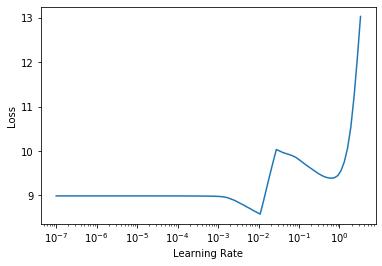

In [15]:
learn.lr_find()

In [16]:
lr = 1e-1
# lr *= bs/48  # Scale learning rate by batch size

In [ ]:
learn.fit_one_cycle(10, lr, wd=wd, moms=moms, div=10, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.626527,4.569241,0.291314,96.470863,1:44:54
1,4.795031,4.810898,0.253669,122.841858,1:44:59
2,4.808968,4.840245,0.249849,126.500374,1:44:55


In [ ]:
#4	4.864285	4.793285	0.316415	120.697197

In [21]:
learn = learn.to_fp32()
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.save(mdl_path/lm_fns[0], with_opt=False)
with open(mdl_path/(lm_fns[1] + '.pkl'), 'wb') as f:
    pickle.dump(learn.dls.vocab, f)

In [20]:
learn.validate()

(#3) [3.9795446395874023,0.387869268655777,53.492671966552734]